# HPC Mini-Challenge 2 - Beschleunigung in Data Science
#### FHNW - FS2022

Original von S. Suter, angepasst für das HS22 von S. Marcin

### Ressourcen
* HPC mit Python – days 1-2 ([Videos](https://www.youtube.com/playlist?list=PL1tk5lGm7zvSC4rLm5Y71372R1Yxl2Dg_), [Github](https://github.com/eth-cscs/PythonHPC)), 2020:
    - JupyterLab Tutorial (z.B. GPU Ressourcen)
    - Introduction
    - Vectorization
    - Profiling
    - JIT Numba CPU 1 + 2
    - Siehe auch aktuelles Tutorial von 2021

Abgabe von: <font color='blue'>Joseph Weibel</font>


## Ausgangslage/Problemstellung


Das menschliche Gehirn verliert mit zunehmendem Alter an Funktion. Ein Teil davon ist "gesundes Altern", d.h. es passiert bei jedem Menschen. Ein relativ großer Prozentsatz der alternden Bevölkerung erlebt jedoch auch einen kognitiven Rückgang, der extremer ist als bei anderen. Eine mildere Version davon wird als 'leichte kognitive Beeinträchtigung' (MCI) bezeichnet, bei der die Person grösstenteils noch funktionieren kann. Bei einem Teil der MCI-Patienten schreitet die Krankheit fort und führt zu Demenz bzw. Alzheimer. In diesem Projekt liegen uns MRI-Bilder des Gehirns von Alzheimerpatienten vor. Im spezifischen analysieren wir die Entwicklung von Alzheimer-Patienten anhand von MRI-Bildern, welche über eine bestimmte Zeit zur Verfügung stehen. Es stellt sich die Frage, wie gut sich die Veränderungen des Krankheitsbildes mittels Korrelationen über die Bildanalyse zeigen lassen. Zur Analyse sind Gigabytes von Daten in Form von 3D Gehirn-Scans vorhanden. Die Verarbeitung dieser grossen Datenmengen kann von Komprimierung profitieren.

Das Verständnis von Gedächtnis- und Kognitionsstörungen und die Möglichkeit, den Gesundheitszustand des Gehirns zu erkennen, vorherzusagen und zu überwachen, ist ein gesellschaftlich und wirtschaftlich relevantes Thema der angewandten Wissenschaft. Alle neuen Erkenntnisse, die datenwissenschaftliche Methoden liefern können, werden zur Entwicklung von Lösungen beitragen, mit denen die Gesundheit des Gehirns erkannt, vorhergesagt und überwacht werden kann.

### Daten
[ADNI (Alzheimer's Disease Neuroimaging Initiative)](https://adni.loni.usc.edu/) ist ein internationales Projekt zur Erfassung von Daten über die Alzheimer-Krankheit und andere verwandte Gehirnerkrankungen, die zu einem kognitiven Abbau führen. Die Initiative wurde mit grossem Enthusiasmus aufgenommen, und viele Mitarbeiter aus der ganzen Welt haben Daten zur Verfügung gestellt, die sie in ihren eigenen Forschungsteams gesammelt haben. Die ADNI-Initiative ist ein öffentliches (gemeinnütziges) Projekt, da viele Forschungseinrichtungen auf der ganzen Welt mit Steuergeldern dazu beigetragen haben. Das bedeutet zwei Dinge: 1) Die Daten stehen uns für Forschungs- und Bildungszwecke zur Verfügung, 2) wir dürfen die Daten nicht an andere weitergeben oder kommerzialisieren.



***Wichtig!*** Die Studierenden dürfen die Daten nur für Forschungszwecke verwenden und erhalten nur einen Beispielsdatensatz. Die ADNI-Daten dürfen nur lokal auf dem Computer oder auf FHNW-Ressourcen wie dem GitLab-Repository, d.h. nicht auf Github, gespeichert werden. Siehe [ADNI Datennutzungsvereinbarung](https://adni.loni.usc.edu/wp-content/uploads/how_to_apply/ADNI_Data_Use_Agreement.pdf).


<img src="images/mri-example.png" alt="MRI example image (coronal slice)" width="150"/> <img src="images/slicing.png" alt="Slicing" width="400"/>

Links: MRI Beispielbild (coronaler Schnitt), rechts: MRI slicing

## Zielsetzung

In dieser Aufgabe sollen die Parallelisierung und Beschleunigung unterschiedlicher Methoden von Bildrekonstruktion basierend auf komprimierten (zerlegten) Daten implementiert, analyisiert und diskutiert werden. Die Rekonstruktion der Daten aus der komprimierten Version soll dabei möglichst in Echtzeit geschehen. 

## Lösungsweg / Vorgehen

Wir lösen diese Aufgabenstellung indem wir die Singulärwertzerlegung (SVD: singular value decomposition) als Kompressionsmethode verwenden (Matrixfaktorisierung). Siehe Abbildungen unten. Um die Rekonstruktion der Daten aus der SVD-Matrixfaktoriseriung möglichst in Echtzeit zu bewerkstelligen, evaluieren wir dafür verschiedene Methoden der Parallelisierung und Beschleunigung in Python. 
* Beschleunigungsvarianten auf der CPU:
    - Numpy Operationen inkl. Broadcasting
    - Numba
    - Threads
* Beschleunigung auf der GPU:
    - Cupy (analog zu Numpy)
    - Numba (analog zu Numba)

<img src="images/svd_reco.png" alt="svd vis" width="300"/> <img src="images/svd.png" alt="svd" width="300"/>

## Daten Zerlegen
### 1.1 Daten laden


In [1]:
import os
import imageio
import numpy as np

subfolder = '001'
folders = os.path.join('adni_png', subfolder)

images = np.empty([7,256,170])
idx = 0
names = []
for filename in os.listdir(folders):
    if filename.endswith('.png') and '145' in filename:
        with open(os.path.join(folders, filename), 'r') as f:
            im = imageio.v2.imread(f.name)
            names.insert(idx,f.name[-17:-4])
            images[idx,:,:] = im
            print (names[idx], im.shape)
            idx += 1
            
print(images.shape)

m1-2_slice145 (256, 170)
m3-2_slice145 (256, 170)
m4-2_slice145 (256, 170)
m3-1_slice145 (256, 170)
m4-1_slice145 (256, 170)
m6-1_slice145 (256, 170)
m1-1_slice145 (256, 170)
(7, 256, 170)


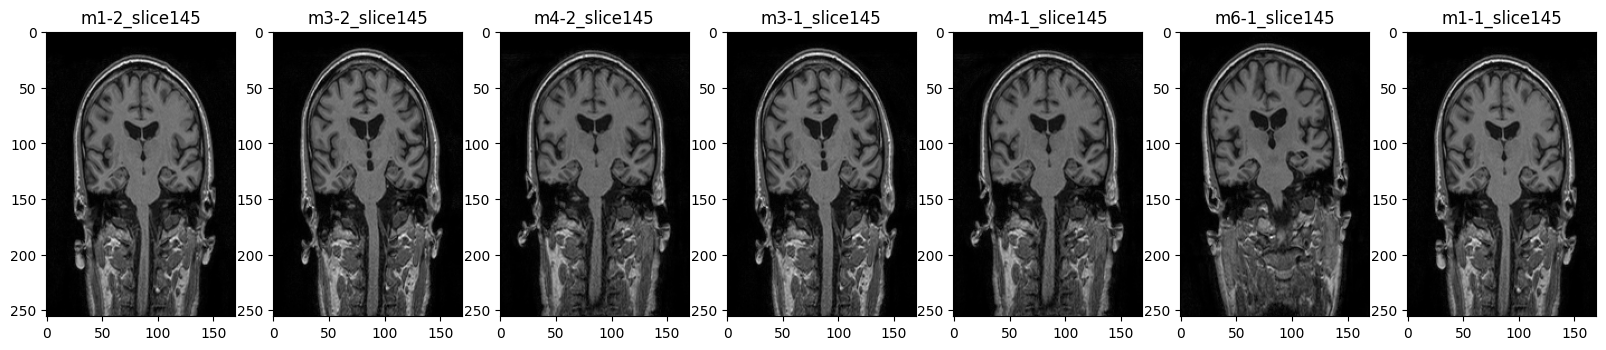

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,10))

for a in range(images.shape[0]):
    ax = fig.add_subplot(1,images.shape[0],a+1)
    ax.imshow(images[a],cmap='gray')
    ax.set_title(names[a])


### 1.2 Daten zerlegen

In [3]:
im = images[0]
im = im -im.min() / im.max() - im.min() # normalize data 
u,s,vt = np.linalg.svd(im, full_matrices=False)

In [4]:
def reconstruct_svd(u,s,vt,k):
    """SVD reconstruction for k components using np.dot()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    reco = np.dot(u[...,:k], np.dot(np.diag(s[:k]), vt[:k,...]))
        
    return reco

In [5]:
from skimage import metrics

# calculate various metrics for the reconstruction quality
def calculate_metrics(im, reco):
    mse = metrics.mean_squared_error(im, reco)
    ssim_score = metrics.structural_similarity(im, reco)
    hdist = metrics.hausdorff_distance(im, reco)
    return f"MSE: {mse:.2f}, SSIM {ssim_score:.2f}, HDIST: {hdist:.2f}"


original size:  43520
decomposed to n =  170 , size:  72590
decomposed to n =  140 , size:  59780
decomposed to n =  110 , size:  46970
decomposed to n =  80 , size:  34160
decomposed to n =  50 , size:  21350


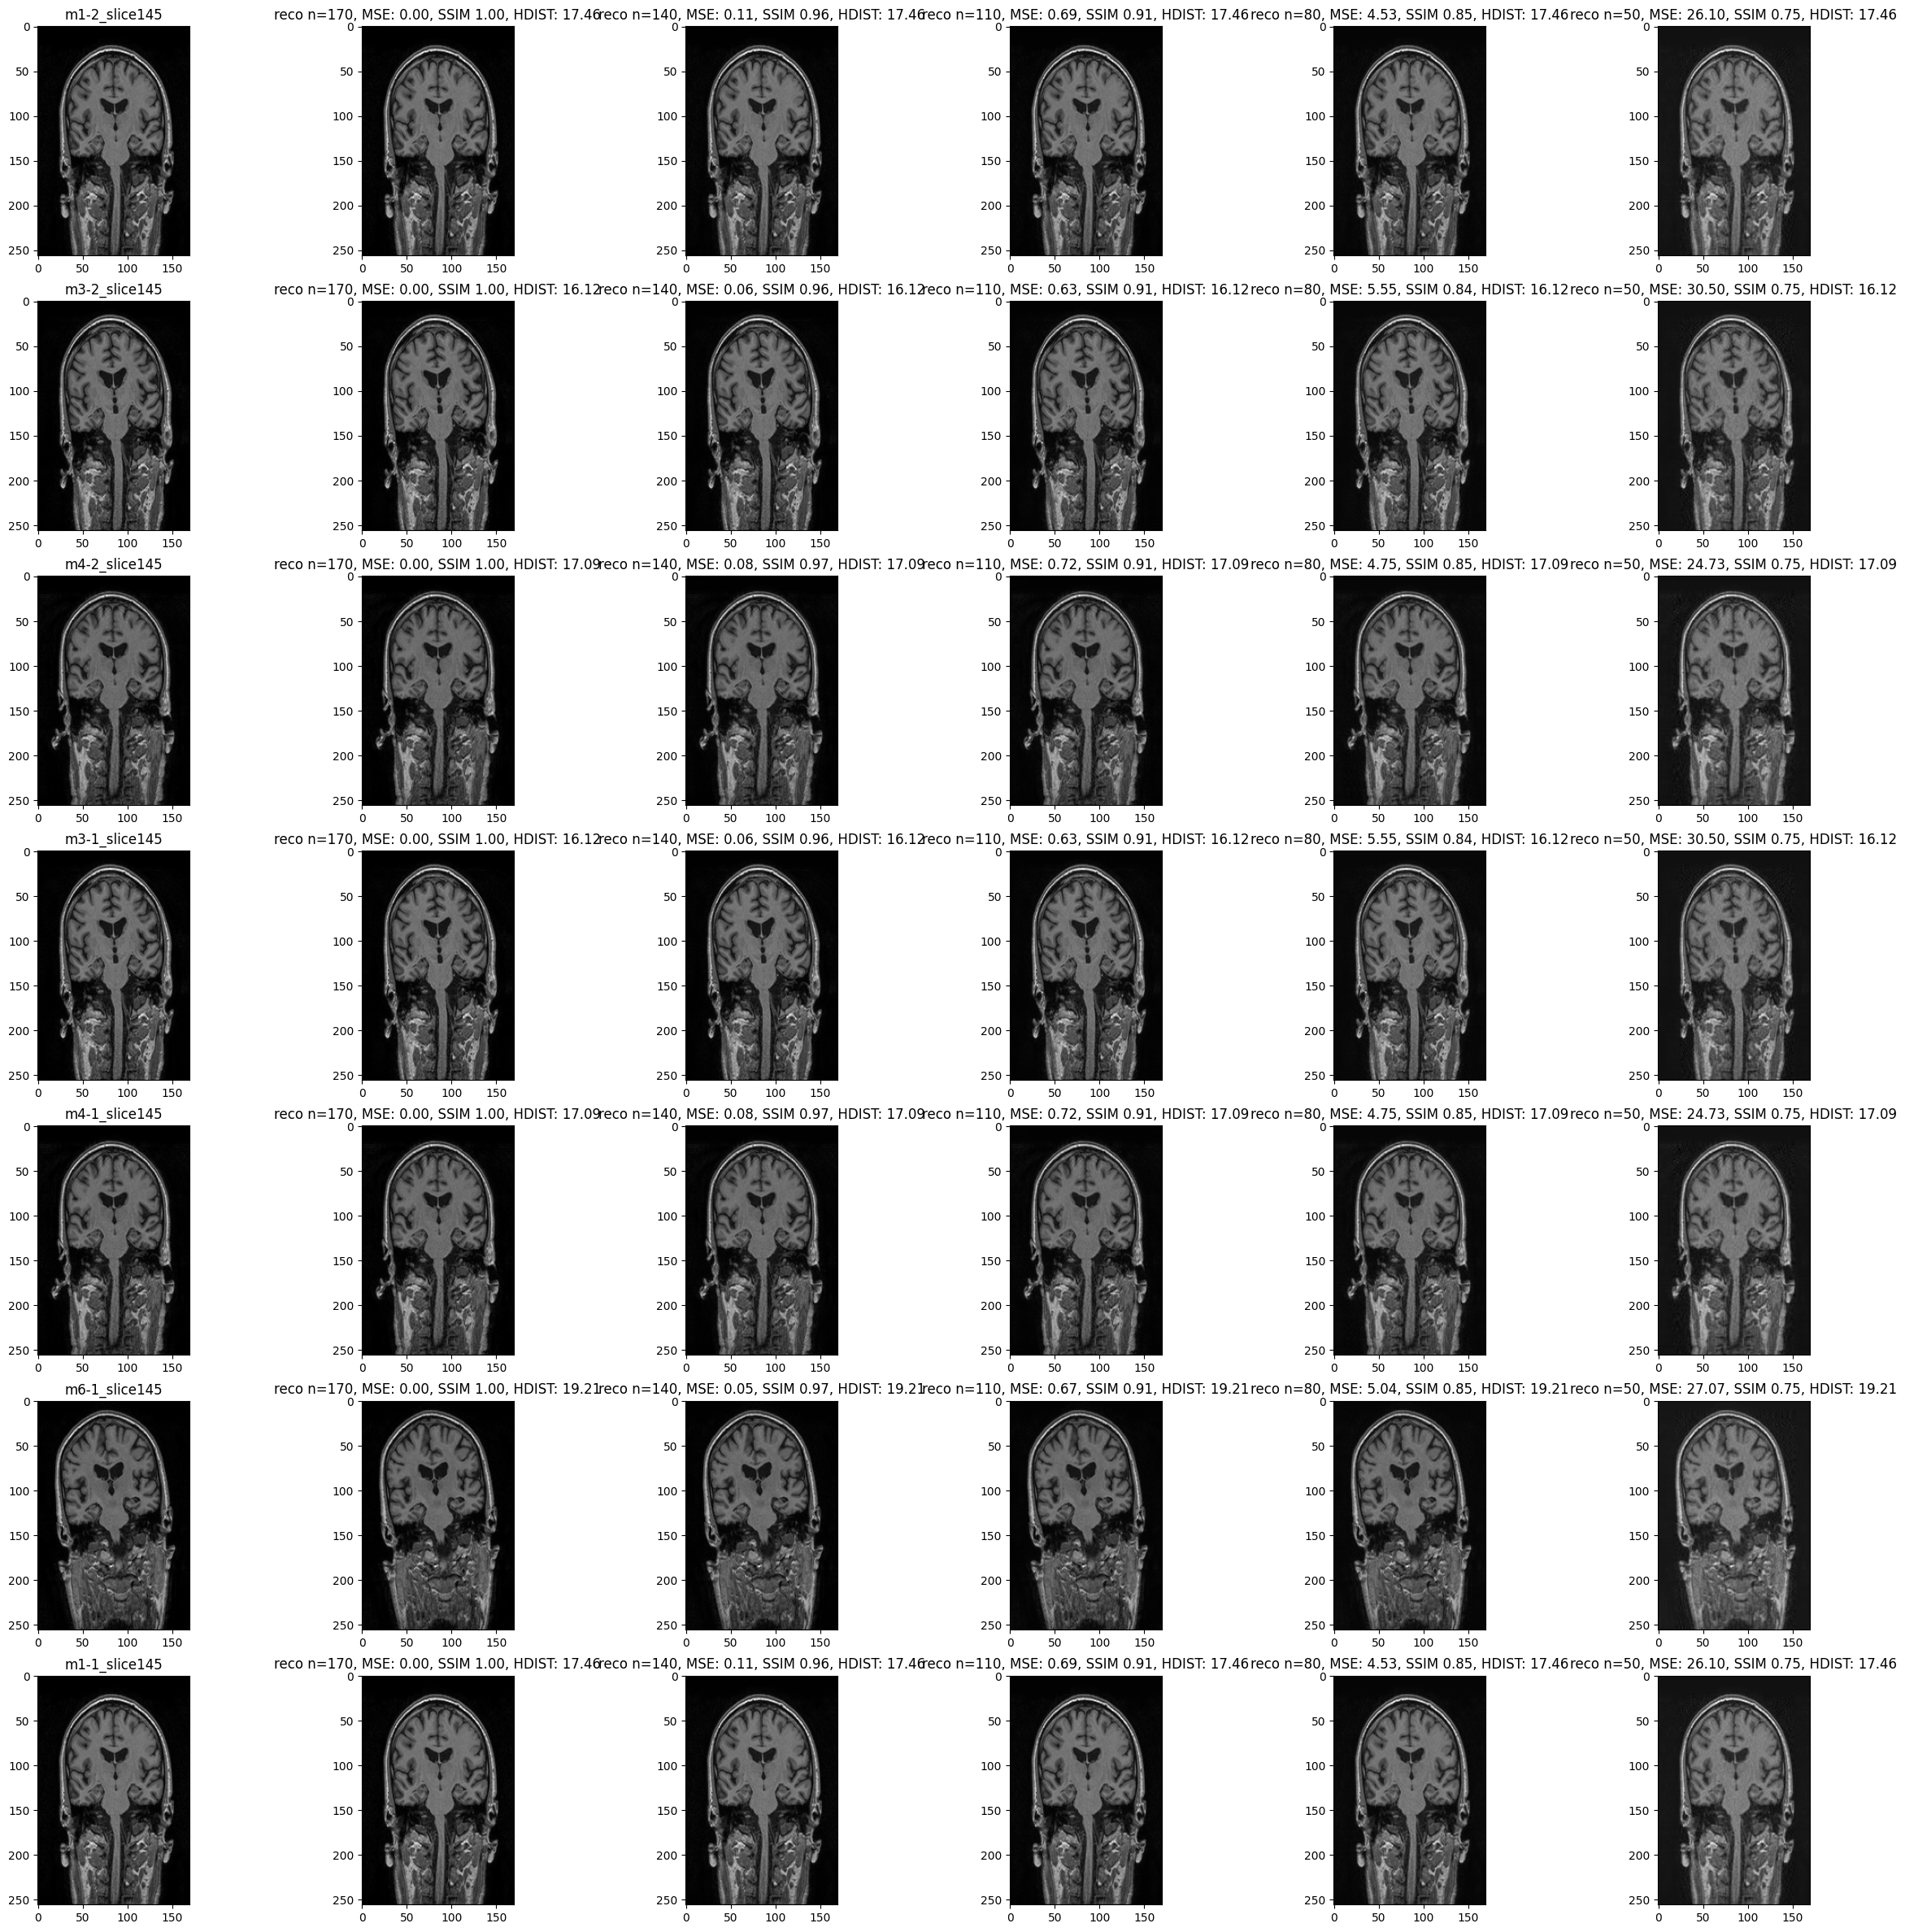

In [6]:
fig, axs = plt.subplots(images.shape[0], 6, figsize=(30,30))

for a in range(images.shape[0]):
    im = images[a]
    im = im -im.min() / im.max() - im.min()    
    u,s,vt = np.linalg.svd(im, full_matrices=False)

    axs[a, 0].imshow(im,cmap='gray')
    axs[a, 0].set_title(names[a])
    
    if (a == 0):
        print('original size: ', im.shape[0]*im.shape[1])
    
    for idx, n in enumerate(range(s.shape[0], 20, -30)):
        reco = reconstruct_svd(u,s,vt,n)
        if (a == 0):
            print('decomposed to n = ', n , ', size: ', u.shape[0] * n + n + vt.shape[0]*n)
    
        axs[a, idx+1].imshow(reco,cmap='gray')
        axs[a, idx+1].set_title('reco n=' + str(n) + ', ' + calculate_metrics(im, reco))
    

### 2 Rekonstruktionsvarianten
Siehe Bilder in der Einführung (Teil: Vorgehen).

In [7]:
# helper function to visualze reconstruction
def plot_reco(reco, k):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(reco,cmap='gray')
    ax.set_title('reco with ' + str(k)+ ' components')

#### 2.1 For-Loops
Rekonstruiere nun die zerlegte SVD Matrix mittels For-Loops gemäss Formel B.4 (oben). Rekonstruiere nur die ersten $k$ Komponenten der SVD-Matrixfaktorisierung $U, S, V^T$, wobei $U \in \mathbb{R}^{MxN}$, $S \in \mathbb{R}^{N}$, und  $V^T \in \mathbb{R}^{NxN}$. 

Implementiere dafür folgende drei Funktionen - jeweils mit 3, 2 bzw. 1 For-Loop:

In [8]:
def reconstruct_svd_for_loops3(u,s,vt,k):
    """SVD reconstruction for k components using 3 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION

    reco = np.zeros((u.shape[0], vt.shape[0]))
    for m in range(u.shape[0]):
        for n in range(vt.shape[0]):
            for p in range(k):
                reco[m, n] += u[m, p] * s[p] * vt[p, n]
            
    ### END SOLUTION

    return reco

In [9]:
def reconstruct_svd_for_loops2(u,s,vt,k):
    """SVD reconstruction for k components using 2 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION

    reco = np.zeros((u.shape[0], vt.shape[0]))
    for m in range(u.shape[0]):
        for n in range(vt.shape[0]):
            reco[m, n] = np.sum(u[m, 0:k] * s[0:k] * vt[0:k, n])
            
    ### END SOLUTION

    return reco

In [10]:
def reconstruct_svd_for_loops1(u,s,vt,k):
    """SVD reconstruction for k components using 1 for-loop and np.outer()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION

    reco = np.zeros((u.shape[0], vt.shape[0]))
    for p in range(k):
        reco += s[p] * np.outer(u[:, p], vt[p, :])
        
    ### END SOLUTION

    return reco

#### 2.2 Einstein Summation
Implementiere nun eine möglichst schnelle Rekonstruktionsvariante mittels `np.einsum()` gemäss folgender Funktion:

In [11]:
def reconstruct_svd_einsum1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    
    reco = np.einsum('mp,p,pn', u[:,0:k], s[0:k], vt[0:k,:])

    ### END SOLUTION

    return reco

#### 2.3 Broadcasting
Implementiere nun zwei Rekonstruktionsvarianten mittels Broadcasting.

Links:
- https://machinelearningmastery.com/broadcasting-with-numpy-arrays/
- https://numpy.org/doc/stable/user/basics.broadcasting.html
- https://eli.thegreenplace.net/2015/broadcasting-arrays-in-numpy/
- https://scipy.github.io/old-wiki/pages/EricsBroadcastingDoc

In [12]:
def reconstruct_svd_broadcast1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast variant 1
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    
    reco = (s[0:k] * u[:,0:k]) @ vt[0:k,:]
    
    ### END SOLUTION

    return reco

In [13]:
def reconstruct_svd_broadcast2(u,s,vt,k):
    """SVD reconstruction for k components using broadcast variant 2
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    
    reco = u[:,0:k] @ (vt[0:k,:] * s[0:k, np.newaxis])

    ### END SOLUTION

    return reco


#### 2.4 Vergleich der Resultate
Vergleiche die Resultate der Implementierungen anhand eines Beispielbildes. Sind die Rekonstruktionen nahezu gleich? Wie sieht es mit der Rekonstruktionsgeschwindigkeit aus - abhängig von der Anzahl rekonstruierter Komponenten?

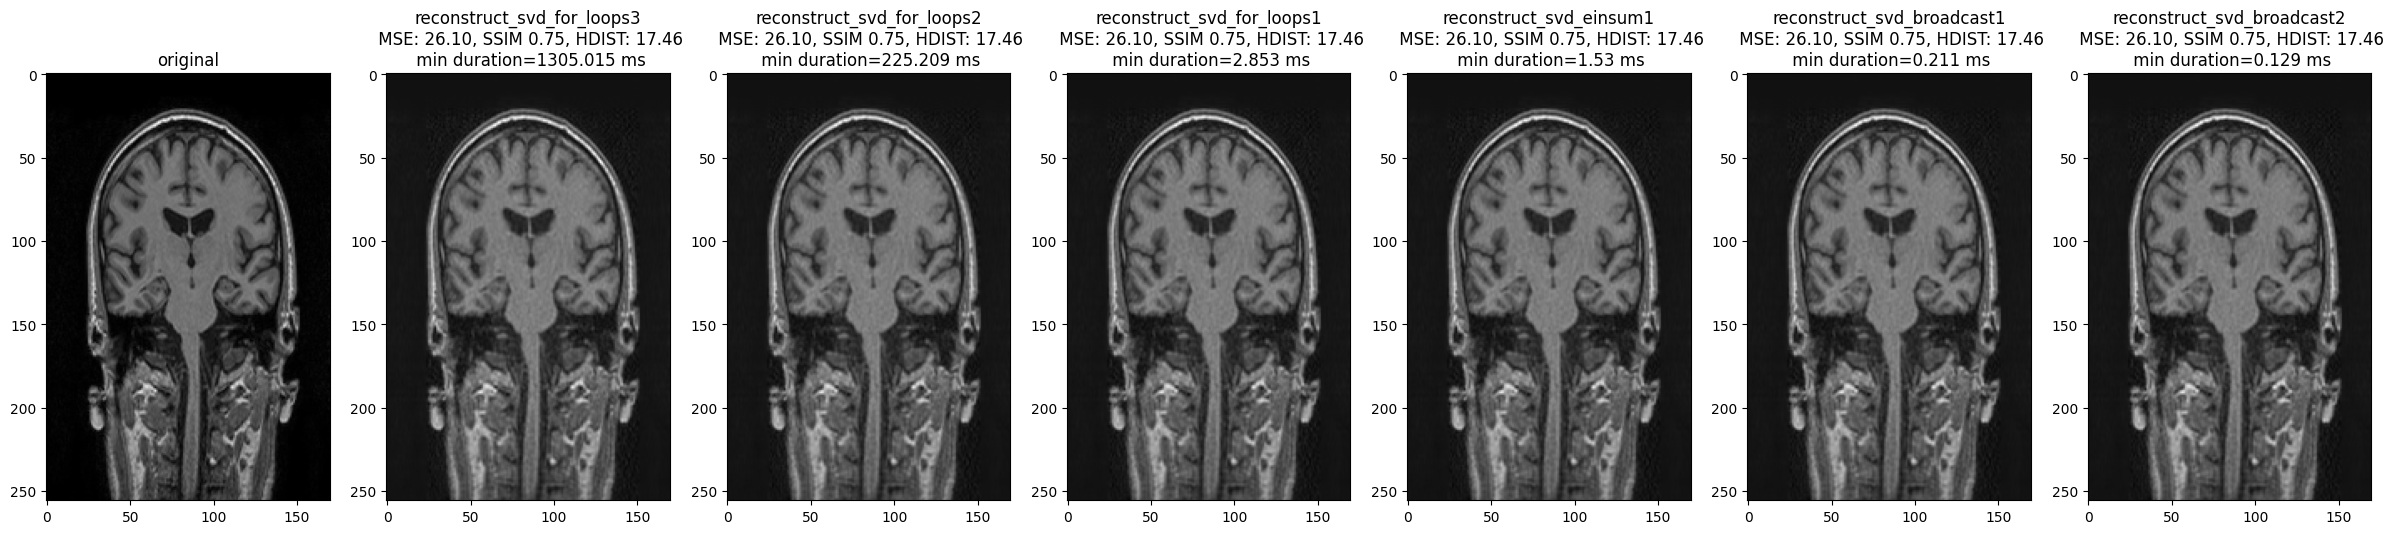

In [14]:
### BEGIN SOLUTION
import timeit

fig, axs = plt.subplots(1, 7, figsize=(30,30))

img = images[0] - images[0].min() / images[0].max() - images[0].min()    
u, s, vt = np.linalg.svd(img, full_matrices=False)

axs[0].imshow(img, cmap='gray')
axs[0].set_title('original')

for idx, fnc in enumerate([
    reconstruct_svd_for_loops3,
    reconstruct_svd_for_loops2,
    reconstruct_svd_for_loops1,
    reconstruct_svd_einsum1,
    reconstruct_svd_broadcast1,
    reconstruct_svd_broadcast2
]):
    times = timeit.repeat(lambda: fnc(u, s, vt, 50), number=1, repeat=3)
    reco = fnc(u, s, vt, 50)
    metrics_str = calculate_metrics(img, reco)

    axs[idx+1].imshow(reco, cmap='gray')
    axs[idx+1].set_title(f'{fnc.__name__}\n {metrics_str}\n min duration={(np.min(times) * 1000).round(3)} ms')
    
### END SOLUTION

In [15]:
### BEGIN SOLUTION


### END SOLUTION

#### 2.5 Interpretation der Resultate

Welche der Implementierungen war am schnellsten? Was waren deine Beobachtungen während  der Implementierung? Wo können solche Optimierungen sonst noch eingesetzt werden? Diskutiere in ca. 150-200 Wörtern.

<font color='blue'>Die Rekonstruktionen sehen bei allen Varianten gleich aus. Und wie erwartet waren die Implementierungen mit den for-Loops deutlich am langsamsten, wobei die Dauer stark zunimmt, je mehr Loops vorhanden sind. Die Einsum-Variante braucht zwar nur noch etwa die Hälfte der Zeit im Vergleich zur schnellsten Loop-Variante, doch scheint sie immer noch relativ langsam zu sein. Insbesondere wenn man diese mit den Broadcasting-Varianten vergleicht, die nur noch einen Bruchteil der Zeit benötigen. Bei Einsum wird womöglich viel Zeit für das Parsing der Rechnungsanweisung benötigt. Bei kleinen Matrizen, bei denen nicht viel gerechnet werden muss, fällt diese stärker ins Gewicht als bei riesigen Matrizen, wo das Verhältnis Parsing zu Berechnung kleiner ausfällt. Broadcasting ist nicht nur sehr schnell, sondern auch eine sehr praktische Funktion, die ich auch unbewusst eingesetzt habe. Bei den Varianten mit zwei und einem for-Loop, mache ich auch davon gebraucht, indem ich einen Skalarwert mit Vektoren resp. Matrizen multipliziere. Ohne Broadcasting, müsste ich dafür sonst manuell den Wert wiederholen, bis ein Vektor oder Matrix mit der passenden Grösse erreicht würde, was die Laufzeit dieser langsamen Versionen nochmals verlängern würde.</font>

### 3 Parallelisierung mittels Numba

Implementiere nun eine möglichst schnelle Rekonstruktionsvariante des SVDs mittels Numba. Ist es möglich, den Code mit Numba zu beschleunigen? Führe dazu eine Diagnostik aus. Wenn ja, was ist der Speedup-Faktor und welche(r) Teil(e) konnte(n) parallelisiert werden? Falls nein, was sind die Gründe, weshalb es sich nicht parallelisieren lässt? Lassen sich verschachtelte Schleifen parallelisieren? Warum? Diskutiere in ca. 150-200 Wörtern, wann und warum sich Numba für die Parallelisierung eignet - anhand deines Beispiels.

Beachte:
* Beim ersten Mal Ausführen des Codes wird die Zeit des Kompilierens mit eingerechnet.
* Numba eignet sich gut für For-Schleifen

In [16]:
import numba

### BEGIN SOLUTION
@numba.jit(parallel=False, nopython=True)
### END SOLUTION
def reconstruct_svd_numba1(u,s,vt,k):
    """SVD reconstruction for k components using numba
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
### BEGIN SOLUTION

    reco = np.zeros((u.shape[0], vt.shape[0]))
    for m in range(u.shape[0]):
        for n in range(vt.shape[0]):
            for p in range(k):
                reco[m, n] += u[m, p] * s[p] * vt[p, n]
                
### END SOLUTION

    return reco

### BEGIN SOLUTION
@numba.jit(parallel=True, nopython=True)
### END SOLUTION
def reconstruct_svd_numba1_parallel(u,s,vt,k):
    """SVD reconstruction for k components using numba
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
### BEGIN SOLUTION

    reco = np.zeros((u.shape[0], vt.shape[0]))
    for m in numba.prange(u.shape[0]):
        for n in numba.prange(vt.shape[0]):
            for p in numba.prange(k):
                reco[m, n] += u[m, p] * s[p] * vt[p, n]
                
### END SOLUTION

    return reco

In [17]:
### BEGIN SOLUTION
@numba.jit(parallel=False, nopython=True)
### END SOLUTION
def reconstruct_svd_numba2(u,s,vt,k):
    """SVD reconstruction for k components using numba
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
### BEGIN SOLUTION

    reco = (s[0:k] * u[:,0:k]) @ vt[0:k,:]
                
### END SOLUTION

    return reco

### BEGIN SOLUTION
@numba.jit(parallel=True, nopython=True)
### END SOLUTION
def reconstruct_svd_numba2_parallel(u,s,vt,k):
    """SVD reconstruction for k components using numba
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
### BEGIN SOLUTION

    reco = (s[0:k] * u[:,0:k]) @ vt[0:k,:]
                
### END SOLUTION

    return reco

/var/folders/23/myl6lfqs0vb07y88xg59b_8c0000gn/T/ipykernel_85209/2946530202.py:18: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  reco = (s[0:k] * u[:,0:k]) @ vt[0:k,:]
/Users/josefweibel/.local/share/virtualenvs/ds-hpc-mini-challenge-2-_0ggGr14/lib/python3.10/site-packages/numba/core/typing/npydecl.py:913: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/var/folders/23/myl6lfqs0vb07y88xg59b_8c0000gn/T/ipykernel_85209/2946530202.py:41: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  reco = (s[0:k] * u[:,0:k]) @ vt[0:k,:]
/Users/josefweibel/.local/share/virtualenvs/ds-hpc-mini-challenge-2-_0ggGr14/lib/python3.10/site-packages/numba/core/typing/npydecl.py:913: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (

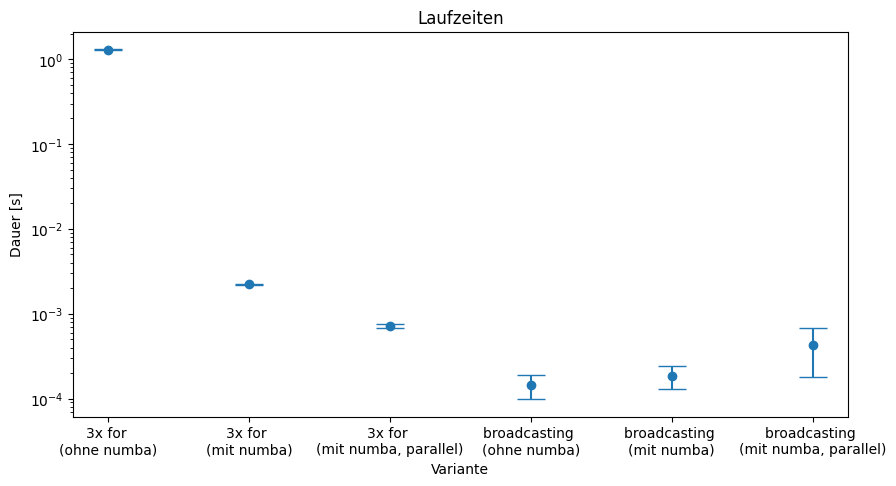

In [18]:
### BEGIN SOLUTION
import pandas as pd

# compile numba functions
reconstruct_svd_numba1(u, s, vt, 50)
reconstruct_svd_numba1_parallel(u, s, vt, 50)
reconstruct_svd_numba2(u, s, vt, 50)
reconstruct_svd_numba2_parallel(u, s, vt, 50)

def plot_runtimes(names, fncs):
    times = []
    for fnc in fncs:
        times.append(timeit.repeat(lambda: fnc(u, s, vt, 50), number=1, repeat=3))
        
    times = np.array(times)
    
    y = times.mean(axis=1)
    plt.figure(figsize = (10, 5))
    plt.errorbar(
        names,
        y,
        times.std(axis=1),
        linestyle='None',
        marker='o', 
        capsize=10
    )
    plt.title('Laufzeiten')
    plt.xlabel('Variante')
    plt.ylabel('Dauer [s]')
    plt.yscale('log')
    plt.show()

    results = pd.DataFrame({'fnc': names, 'mean duration (s)': y})
    results.fnc = results.fnc.str.replace('\n', '')
    results

plot_runtimes(
    ['3x for \n(ohne numba)', '3x for \n(mit numba)', '3x for \n(mit numba, parallel)', 'broadcasting \n(ohne numba)', 'broadcasting \n(mit numba)', 'broadcasting \n(mit numba, parallel)'],
    [reconstruct_svd_for_loops3, reconstruct_svd_numba1, reconstruct_svd_numba1_parallel, reconstruct_svd_broadcast1, reconstruct_svd_numba2, reconstruct_svd_numba2_parallel]
)


### END SOLUTION

In [19]:
reconstruct_svd_numba1_parallel.parallel_diagnostics(level=3)

 
 Parallel Accelerator Optimizing:  Function reconstruct_svd_numba1_parallel, 
/var/folders/23/myl6lfqs0vb07y88xg59b_8c0000gn/T/ipykernel_85209/1098544619.py 
(31)  


Parallel loop listing for  Function reconstruct_svd_numba1_parallel, /var/folders/23/myl6lfqs0vb07y88xg59b_8c0000gn/T/ipykernel_85209/1098544619.py (31) 
----------------------------------------------------------------------------|loop #ID
@numba.jit(parallel=True, nopython=True)                                    | 
### END SOLUTION                                                            | 
def reconstruct_svd_numba1_parallel(u,s,vt,k):                              | 
    """SVD reconstruction for k components using numba                      | 
                                                                            | 
    Inputs:                                                                 | 
    u: (m,n) numpy array                                                    | 
    s: (n) numpy array (diagonal matri

<font color='blue'>Durch numba konnte die langsame Variante mit 3 for-Loops um den Faktor 600 verschnellert werden, indem nur der Decorator ergänzt wurde. Auch die schnelle Broadcasting-Variante konnte mit dem Decorator im Schnitt leicht beschleunigt werden, wobei die Verbesserung noch im Unsicherheitsbereich liegt. Die Variante mit dreifachem Loop konnte durch Parallelisierung weiter verbessert werden, jedoch zeigt die Diagnostik, dass nur der äusserste Loop parallelisiert wurde. Dies scheint eine allgemeine Einschränkung dieses Compilers zu sein, denn eigentlich wäre es möglich die Zeile mit der Berechnung auf mehrere Threads bzw. Prozesse aufzuteilen. Möglicherweise kann man das Problem umgehen, indem man das kartesische Produkt aus den Ranges der drei Loops bildet und einen einzelnen Loop erstellt, der diese Parameterkombination abarbeitet. Die Broadcasting-Variante wurde durch die Parallelisierung verlangsamt, da der Code keine Schleifen enthält und ausschliesslich aus Matrizen- und Vektoroperationen besteht. Die verlängerte Laufzeit ist auf den Overhead durch die Parallelisierung zurückzuführen.</font>

### 4 Parallelisierung mit Threads

Als nächstes Parallelisieren wir die Rekonstruktion der SVD zerlegten Matrizen mittels unterschiedlichen Thread-Varianten.

Links:
* Threading in Python ([Videokurs](https://realpython.com/courses/threading-python/), [Blogartikel](https://realpython.com/intro-to-python-threading/), [Quiz](https://realpython.com/quizzes/python-threading/)), RealPython
* https://github.com/eth-cscs/PythonHPC/tree/master/intro
* Slides vom Kurs kvanc zum Thema IPC mittels Python

#### 4.1 Einzelne Threads auf einer CPU

Implementiere eine Funktion, welche ein Rekonstruktionsschritt in Thread rekonstruiert. Wähle selbst welchen Schritt du mittels Threading implementierst. Verwende dabei geeignete Lock-Mechanismen. Verwende vor und nach den Lock-Mechanismen geeignete Print/Log-Statements und verwende unterschiedliche Farben der Print-Statements für die Threads. Validiere dein Ergebnis der Rekonstruktion indem du mehrere Threads für einzelne Rekonstruktionsschritte aufruftst.

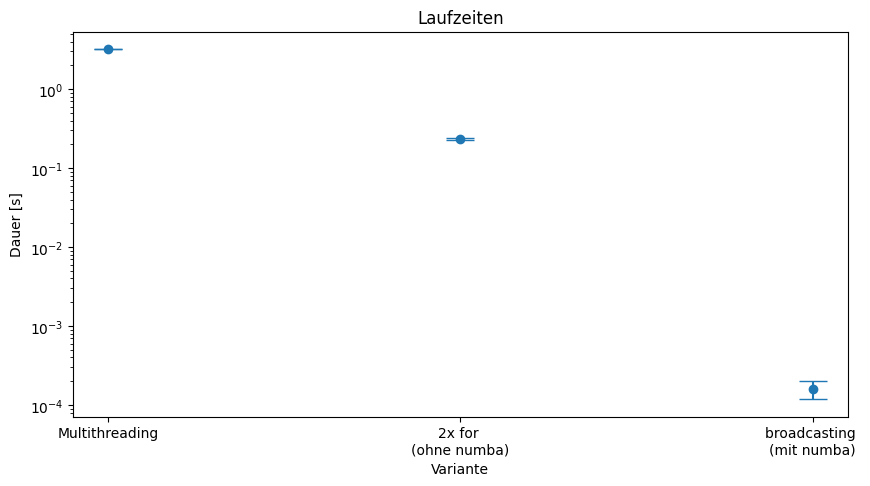

In [20]:
### BEGIN SOLUTION
from threading import Thread, current_thread

def reconstruct_and_set_svd_coordinate(reco,m,n,u,s,vt,k):
    # print(f'[{current_thread().ident}][Start] reconstructing pixel {m}/{n}')
    reco[m, n] = np.sum(u[m, 0:k] * s[0:k] * vt[0:k, n])
    # print(f'[{current_thread().ident}][ End ] reconstructing pixel {m}/{n}')

def reconstruct_svd_threads(u,s,vt,k):
    """SVD reconstruction for k components using threads
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """

    reco = np.zeros((u.shape[0], vt.shape[0]))
    
    threads = []
    for m in range(u.shape[0]):
        for n in range(vt.shape[0]):
            thread = Thread(target=reconstruct_and_set_svd_coordinate, args=[reco, m, n, u, s, vt, k])
            thread.start()
            threads.append(thread)
            
    for thread in threads:
        thread.join()
            
    return reco

plot_runtimes(
    ['Multithreading', '2x for \n(ohne numba)', 'broadcasting \n(mit numba)'],
    [reconstruct_svd_threads, reconstruct_svd_for_loops2, reconstruct_svd_numba2]
)

### END SOLUTION



In [21]:
### BEGIN SOLUTION

### END SOLUTION

color1 = '\033[91m'  # red
color2 = '\033[92m'  # green
color3 = '\033[93m'  # yellow
color4 = '\033[94m'  # blue

#### 4.2 Bonus: Thread-Pool-Executor

Rufe zum Vergleich die unabhängige Rekonstruktionsschritte mittels eines Thread-Pool-Executors auf.

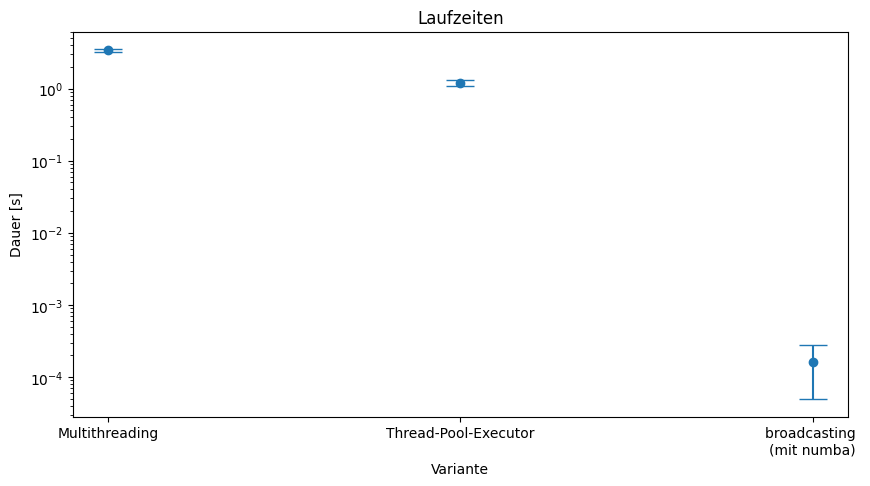

In [22]:
### BEGIN SOLUTION

from concurrent.futures import ThreadPoolExecutor

def reconstruct_svd_thread_pool_executor(u,s,vt,k):
    """SVD reconstruction for k components using a thread pool executor
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """

    reco = np.zeros((u.shape[0], vt.shape[0]))
        
    with ThreadPoolExecutor(max_workers=10) as executor:
        for m in range(u.shape[0]):
            for n in range(vt.shape[0]):
                executor.submit(reconstruct_and_set_svd_coordinate, reco, m, n, u, s, vt, k)
            
    return reco

plot_runtimes(
    ['Multithreading', 'Thread-Pool-Executor', 'broadcasting \n(mit numba)'],
    [reconstruct_svd_threads, reconstruct_svd_thread_pool_executor, reconstruct_svd_numba2]
)

### END SOLUTION

#### 4.3 Bonus: Threads auf mehreren CPUs

Verwende anstelle von Threading Multiprocessing damit die Threads auf mehrere CPUs verteilt werden.

Links:
* Concurrency [Blog](https://realpython.com/python-concurrency/), [Quiz](https://realpython.com/quizzes/python-concurrency/), RealPython


[Process-2] START
[Process-2] DONE
[Process-4] START
[Process-4] DONE
[Process-3] START
[Process-3] DONE
[Process-5] START
[Process-5] DONE
[Process-8] START
[Process-8] DONE
[Process-7] START
[Process-7] DONE
[Process-9] START
[Process-9] DONE
[Process-10] START
[Process-10] DONE
[Process-13] START
[Process-13] DONE
[Process-15] START
[Process-15] DONE
[Process-14] START
[Process-14] DONE
[Process-12] START
[Process-12] DONE


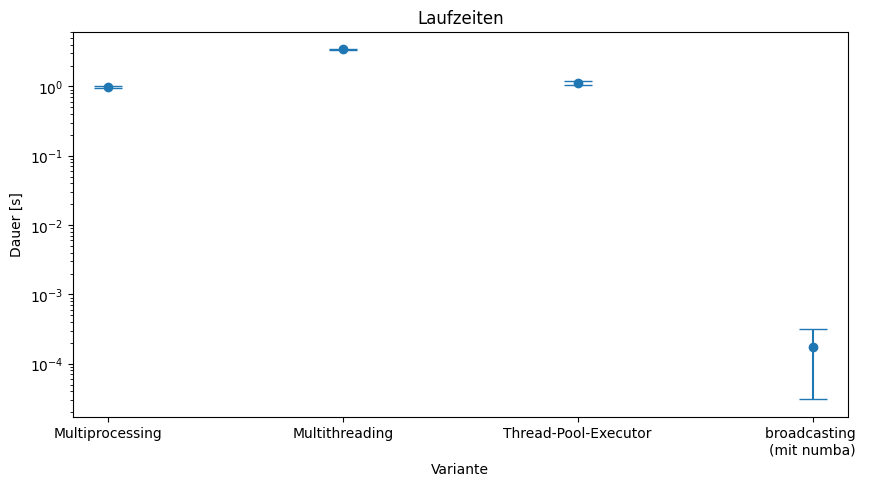

In [23]:
### BEGIN SOLUTION

from lib import reconstruct_svd_processes

plot_runtimes(
    ['Multiprocessing', 'Multithreading', 'Thread-Pool-Executor', 'broadcasting \n(mit numba)'],
    [reconstruct_svd_processes, reconstruct_svd_threads, reconstruct_svd_thread_pool_executor, reconstruct_svd_numba2]
)

### END SOLUTION

#### 4.4 Analyse

1. Macht es in diesem Beispiel Sinn Threads zu benutzen? Wann ist es sinnvoll Threads zu benutzen? Beschreibe in 2-3 Sätzen warum. 

<font color='blue'>In diesem Fall macht es eher weniger Sinn, da hier nicht auf IO gewartet werden muss, sondern es sich hier eigentlich nur um Berechnungsoperationen auf der CPU handelt. Threads in Python laufen nicht gleichzeitig, sondern erlauben es, dass ein anderer Thread ausgeführt wird, während ein anderer Thread auf externe Ressourcen wartet.</font>

2. Könnten in diesem Beispiel auch andere Code-Teile auf mehreren Threads aufgerufen werden? Welche würden sich eignen? Welche nicht? Beschreibe in 2-3 Sätzen warum. 

<font color='blue'>Der Einsatz von Threads lohnt sich bei einer Matrixmultiplikation eher weniger, da diese sehr rechenintensiv ist und dadurch der Vorteil von Threads nicht angewendet werden kann. Das Berechnen einzelner Pixel ist einfach umzusetzen, da so kein Locking nötig ist. Bei Verfahren, bei denen ein Pixel aus mehreren Operationen zusammengesetzt wird, die in mehreren Threads ausgeführt werden, muss zwischen dem Lesen des bestehenden Werts für einen Pixel und dem Schreiben des aktualisierten Pixels dafür gesorgt werden, dass kein anderer Thread währenddessen den Pixel verwendet. Dadurch können andere Threads blockiert werden und ingesamt beansprucht Locking zusätzliche Ressourcen.</font>

3. Was sind die Unterschiede (auch bzgl. Leistung) der manuellen Ausführung des Threadings vs. dem Benutzen eines Thread-Pool-Executors oder von Multiprocessing?

<font color='blue'>Durch die Verwendung eines Thread-Pool-Executors wird das Handling der Threads vereinfacht, insbesondere wenn man eine bestimmte Anzahl an Tasks hat, die man auf eine kleinere Menge an Threads verteilen möchte. Man könnte dies auch selbst mit einer Queue und mehreren Thread-Instanzen implementieren. Der grosse Vorteil von Multiprocessing ist, dass damit wirklich Gleichläufigkeit erzielt werden kann. Bei Multithreading wird nur bei blocking Operations (zum Beispiel I/O-Zugriffe) ein anderer Thread gestartet. Der Prozess läuft dennoch nur auf einem CPU-Core. Mit Multiprocessing werden separate Python-Prozesse gestartet, die gleichzeitig auf mehreren CPU-Cores ausgeführt werden konnen. Es ist jedoch zu beachten, dass das Starten eines Threads zusätzliche Ressourcen beansprucht. Dies ist auch bei Prozessen der Fall. Hier ist der Overhead nochmals um einiges grösser als bei Threads. Auch ist die Kommunikation zwischen Prozessen komplexer als zwischen Threads. In beiden Fällen muss bei Operationen, die atomar ausgeführt werden sollen, darauf geachtet werden, dass diese nicht unterbrochen werden, oder von anderen Prozessen beeinflusst werden. Der Overhead für Threads und Prozesse lohnt sich in unserem Fall nicht, wie am obigen Plot zu erkennen ist. Die Matrixmultiplikation ist eine rechenintensive Operation und wir müssen nicht auf I/O warten, weshalb sich Threads nicht eignen. Die Matrizen sind aber auch zu klein, so dass sich der Overhead für Prozesse lohnen würde. Die Prozesse könnte man zusätzlich noch optimieren, dass sie nicht zufällig irgendwelche Koordinaten in der Matrix berechnen, sondern dass man eine zeilen- oder spaltenweise Aufteilung vornehmen würden. Dadurch könnte das Kopieren von Werten in die Caches des CPU-Cores reduziert werden.</font>